Import Package
=======================

In [2]:
pip install pytorch-nlp

     |████████████████████████████████| 92kB 5.6MB/s 


In [3]:
import torch
from torchnlp.word_to_vector import GloVe
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd.variable import Variable
import seaborn as sns
import numpy as np

Import dataset
=========================

In [16]:
numwords = 50000
max = 200
from tensorflow.keras.datasets import imdb
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) \
= imdb.load_data(num_words=numwords, skip_top=0, seed=500)
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items() if i < numwords}

In [17]:
Y_train = torch.from_numpy(Y_train_numpy).type(torch.float).cuda()
Y_test = torch.from_numpy(Y_test_numpy).type(torch.float).cuda()
print(f"Y_train is {Y_train.size()}, Y_test is {Y_test.size()}")

Y_train is torch.Size([25000]), Y_test is torch.Size([25000])


In [18]:
[id2word[id] for id in X_train_numpy[3]]

['the',
 'rescued',
 'sarne',
 'dramas',
 'westerns',
 'i',
 'i',
 'trait',
 'it',
 'by',
 'br',
 'only',
 'seen',
 'starts',
 'poe',
 'usage',
 "it's",
 'making',
 'wake',
 'in',
 'at',
 'up',
 'price',
 'and',
 'it',
 'of',
 'because',
 'old',
 'if',
 'each',
 'in',
 'atmosphere',
 'that',
 'movie',
 'of',
 'try',
 'br',
 'males',
 'lively',
 'of',
 "matsumoto's",
 'who',
 'of',
 'tribe',
 'movie',
 'ridiculous',
 'it',
 'is',
 "posey's",
 'br',
 'described',
 'unwritten',
 'sap',
 'to',
 'decided',
 'which',
 'savvy',
 'sap',
 'to',
 'make',
 'information',
 'action',
 'could',
 'that',
 'himself',
 'in',
 'of',
 'night',
 'just',
 'howard',
 'explains',
 'generation',
 'i',
 'i',
 'poe',
 'never',
 'is',
 'dialog',
 'ghost',
 'gw',
 'vivek',
 'action',
 'at',
 'by',
 'br',
 'be',
 'disgruntled',
 'amongst',
 'sign',
 'opposite',
 "gino's",
 'of',
 '1936',
 'in',
 'so',
 'and',
 'his',
 'but',
 'pretty',
 'br',
 'and',
 'looks',
 'civilian',
 'eartha',
 'like',
 'with',
 'be',
 'sta

Import Glove
===========================

In [ ]:
glove = GloVe(name='6B', dim=50)

glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|██████████| 400000/400000 [00:17<00:00, 22686.14it/s]


In [ ]:
glove['cat', 'dog']

tensor([[ 0.4528, -0.5011, -0.5371, -0.0157,  0.2219,  0.5460, -0.6730, -0.6891,
          0.6349, -0.1973,  0.3368,  0.7735,  0.9009,  0.3849,  0.3837,  0.2657,
         -0.0806,  0.6109, -1.2894, -0.2231, -0.6158,  0.2170,  0.3561,  0.4450,
          0.6089, -1.1633, -1.1579,  0.3612,  0.1047, -0.7832,  1.4352,  0.1863,
         -0.2611,  0.8328, -0.2312,  0.3248,  0.1449, -0.4455,  0.3350, -0.9595,
         -0.0975,  0.4814, -0.4335,  0.6945,  0.9104, -0.2817,  0.4164, -1.2609,
          0.7128,  0.2378],
        [ 0.1101, -0.3878, -0.5762, -0.2771,  0.7052,  0.5399, -1.0786, -0.4015,
          1.1504, -0.5678,  0.0039,  0.5288,  0.6456,  0.4726,  0.4855, -0.1841,
          0.1801,  0.9140, -1.1979, -0.5778, -0.3799,  0.3361,  0.7720,  0.7556,
          0.4551, -1.7671, -1.0503,  0.4257,  0.4189, -0.6833,  1.5673,  0.2768,
         -0.6171,  0.6464, -0.0770,  0.3712,  0.1308, -0.4514,  0.2540, -0.7439,
         -0.0862,  0.2407, -0.6482,  0.8355,  1.2502, -0.5138,  0.0422, -0.8812,


In [ ]:
l = [id2word[id] for id in X_train_numpy[1]]
input = glove[[id2word[id] for id in X_train_numpy[1]]]
input.size()

torch.Size([189, 50])

LSTM
=======================
1. input_size = feature dim of word vector, here we use glove
(dim=50) so input_size = 50  
2. input: [word_num, input_size]  

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.logr = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, input, hidden, state):  # input: batch, seq_len, input_size
        input = input.view(1, input.size()[0], input.size()[1])
        output, (hn, cn) = self.lstm(input, (hidden, state))
        output = output.view(1, -1)
        output = self.logr(output).view(1)
        
        return output

    def initHiddenState(self):
        return torch.zeros(self.hidden_size).view(1, 1, -1).cuda(), torch.zeros(self.hidden_size).view(1, 1, -1).cuda()

Implement
=================

epoch is 49, acc_rate is 0.51, loss is 0.3596391975879669
epoch is 99, acc_rate is 0.51, loss is 0.16819250583648682
epoch is 149, acc_rate is 0.59, loss is 0.2176244556903839
epoch is 199, acc_rate is 0.675, loss is 0.2253083735704422
epoch is 249, acc_rate is 0.685, loss is 0.4429119825363159
epoch is 299, acc_rate is 0.725, loss is 0.002462622243911028
epoch is 349, acc_rate is 0.705, loss is 0.017050936818122864
epoch is 399, acc_rate is 0.77, loss is 0.03485612943768501
epoch is 449, acc_rate is 0.79, loss is 0.017761539667844772
epoch is 499, acc_rate is 0.75, loss is 0.1037173941731453
epoch is 549, acc_rate is 0.81, loss is 0.0002018611558014527
epoch is 599, acc_rate is 0.79, loss is 0.007455154322087765
epoch is 649, acc_rate is 0.865, loss is 0.0001551905443193391
epoch is 699, acc_rate is 0.82, loss is 0.004525417927652597
epoch is 749, acc_rate is 0.83, loss is 0.006548055447638035
epoch is 799, acc_rate is 0.86, loss is 5.959720056125661e-06
epoch is 849, acc_rate is 0.86

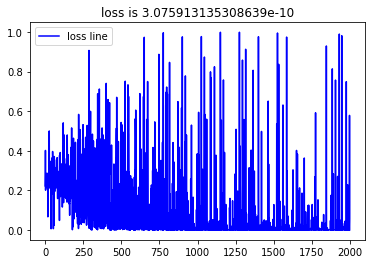

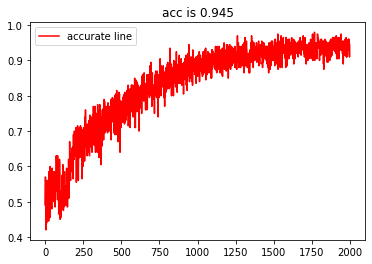


loss is 0.9919793009757996, acc_rate is 0.74272


In [ ]:
from tqdm.notebook import tnrange, tqdm_notebook

lstm1 = LSTM1(50, 500, 1).cuda()
lstm1_optimizer = optim.Adam(lstm1.parameters(), lr = 0.001)

# loss function
loss_function = nn.MSELoss()

# init acc
acc = 0

# batch size
batch_size = 200

# list
epoch_list = []
loss_list = []
acc_rate_list = []

for ep in tnrange(2000):

    acc = 0

    for i in range(batch_size):

        # t
        t = (ep * batch_size + i) % 25000

        # initial hidden layer
        h_0, s_0 = lstm1.initHiddenState()
        # initial learnable parameters
        lstm1.zero_grad()

        input = glove[[id2word[id] for id in X_train_numpy[t]]].cuda()
        output = lstm1(input, h_0, s_0)
        
        loss = loss_function(output, Y_train[t].view(1))
        # print((output.size(), Y_train[i].view(1).size()))
        loss.backward()
        nn.utils.clip_grad_norm_(lstm1.parameters(), 5)
        lstm1_optimizer.step()

        # calculate accurate rate
        pred = np.round(output.cpu().detach().numpy())
        if pred[0] == Y_train[t].cpu().detach().numpy():
            acc += 1
    
    acc_rate = acc / batch_size
    if (ep + 1) % 50 == 0:
        print(f"epoch is {ep}, acc_rate is {acc_rate}, loss is {loss}")

    epoch_list.append(ep)
    loss_list.append(loss.item())
    acc_rate_list.append(acc_rate)

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='blue', label='loss line', ax=ax)
plt.title(f"loss is {loss.item()}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=acc_rate_list, color='red', label='accurate line', ax=ax)
plt.title(f"acc is {acc_rate}")
plt.show()



N_test = Y_test_numpy.shape[0]
acc_test = 0
for t in tnrange(N_test):
    input = glove[[id2word[id] for id in X_test_numpy[t]]].cuda()
    output = lstm1(input, h_0, s_0)
    loss_test = loss_function(output, Y_test[t].view(1))
    pred = np.round(output.cpu().detach().numpy())
    if pred[0] == Y_test[t].cpu().detach().numpy():
        acc_test += 1
acc_rate_test = acc_test / N_test
print(f"loss is {loss_test}, acc_rate is {acc_rate_test}")

Test
==================

In [ ]:
N_test = Y_test_numpy.shape[0]
acc_test = 0
for t in tnrange(N_test):
    input = glove[[id2word[id] for id in X_test_numpy[t]]].cuda()
    output = lstm1(input, h_0, s_0)
    loss_test = loss_function(output, Y_test[t].view(1))
    pred = np.round(output.cpu().detach().numpy())
    if pred[0] == Y_test[t].cpu().detach().numpy():
        acc_test += 1
acc_rate_test = acc_test / N_test
print(f"loss is {loss_test}, acc_rate is {acc_rate_test}")


loss is 0.10406403243541718, acc_rate is 0.77472
